In [1]:
import sys
sys.path.append("..")

In [2]:
from matplotlib import rc
rc('text', usetex=True)

from squlearn.encoding_circuit.encoding_circuit_derivatives import *

import numpy as np
from scipy.integrate import odeint
from solvers.MMR.kernel_solver import Solver
from solvers.MMR.PQK_solver import PQK_solver
from solvers.MMR.FQK_solver import FQK_solver
from DE_Library.diferential_equation_functionals import *


from utils.rbf_kernel_tools import *
from circuits.circuits import *
import pandas as pd


import matplotlib.pyplot as plt

To run this notebook it is necessary to have installed my branch of squlearn installed

We must define a loss functional to be solved

For SHO:

\begin{equation}
L\left(\frac{d^2f(x)}{dx^2}, f(x), x\right) = \frac{d^2f(x)}{dx^2} + f(x)
\end{equation}

In [3]:
#Our function assume that the input is a tensor of shape (n, 4) where n is the number of points, each entry corresponds to 
#x, f, dfdx and dfdxdx as shown below
def loss_harmonic_oscillator(f_alpha_tensor):
    """
    Returns the gradient of the loss function for the ODE problem

    Args:
        f_array (np.array): array of shape (n, 4) where n is the number of points, each entry corresponds to 
    x, f, dfdx and dfdxdx. This is: f_array = [x, f, dfdx, dfdxdx]

    Returns:

    grad_loss (np.array): array of shape [dFdf, dFdfdx, dFdfdxdx] 
    where dFdf is the derivative of the loss function with respect to f, dFdfdx is the derivative of the loss function with respect to dfdx and dFdfdxdx is the derivative of the loss function with respect to dfdxdx
   
    """
    x, f, dfdx, dfdxdx = f_alpha_tensor

    return dfdxdx + f

def grad_loss_harmonic_oscillator(f_alpha_tensor):
    """
     Returns the gradient of the loss function for the ODE problem

    Args:
        f_array (np.array): array of shape (n, 4) where n is the number of points, each entry corresponds to 
    x, f, dfdx and dfdxdx. This is: f_array = [x, f, dfdx, dfdxdx]

    Returns:

    grad_loss (np.array): array of shape [dFdf, dFdfdx, dFdfdxdx] 
    where dFdf is the derivative of the loss function with respect to f, dFdfdx is the derivative of the loss function with respect to dfdx and dFdfdxdx is the derivative of the loss function with respect to dfdxdx

    """
    x, f, dfdx, dfdxdx = f_alpha_tensor
    k = 1
    return [k, 0, 1]

The kernel solver only requires the loss function, however the qnn solver also require that the gradient of the loss function is calculated. Then, the gradient with regards to derivatives of the function of $f(x)$ must be calculated.

\begin{equation}
L(x) = d^2f(x)/dx + f(x) \implies \nabla L = \left(\partial/\partial(f) L, \partial/\partial(df/dx) L, \partial/\partial(d^2f/dx^2)  \right)
\end{equation}

For the SHO, we have
\begin{equation}
L(x) = d^2f(x)/dx + k f(x) \implies \nabla L = (k, 0, 1  )
\end{equation}



In [4]:

def derivatives_loss_harmonic_oscillator(f_alpha_tensor, x_span):
    """
    Returns the derivatives of the loss function for the ODE problem. This is used for the scipy odeint solver, which requires the the the ODE to be in the form dfdx = g(f, x)
    Args:
        f_alpha_tensor (np.array): array of shape (n, 2) where n is the number of points, each entry corresponds to the value of the function f at each point and the derivative of the function at each point. This is: f_alpha_tensor = [f, dfdx]
    
    Returns:
        derivatives = [dfdx, dfdxdx] = [dfdx, -f] rewritting with the sho equation

    derivatives = [dfdx, dfdxdx] = [dfdx, -f] rewritting with the sho equation

    
    """
    f = f_alpha_tensor[0]
    dfdx = f_alpha_tensor[1]
    k = 1
    return [dfdx, -k*f]

# Kernel DE Solver

In [5]:
x_line = np.linspace(-0.9, 0.9, 40) #x domain to solve the ODE
k = 1

f_initial = [np.cos(np.sqrt(k)*x_line[0]), -np.sin(np.sqrt(k)*x_line[0])] #Initial condition for the ODE
#Exact result
f_exact = np.cos(np.sqrt(k)*x_line)
#Numerical result
f_odeint = odeint(derivatives_loss_harmonic_oscillator, f_initial, x_line[:])[:,0].flatten()

In [9]:
#Classical Solver
#RBF
sigma = 2.5
RBF_kernel_list = [rbf_kernel_manual(x_line, x_line, sigma), analytical_derivative_rbf_kernel(x_line, x_line, sigma), analytical_derivative_rbf_kernel_2(x_line, x_line, sigma)]
Solver_test = Solver(RBF_kernel_list, regularization_parameter=1)
solution_RBF, loss_by_iteration_RBF = Solver_test.solver(x_line, f_initial, L_functional = loss_harmonic_oscillator)
f_RBF, optimal_alpha_RBF = solution_RBF 

#Quantum Solvers
#PQK
sigma = 1.5
PQK_solver_test = PQK_solver({"encoding_circuit": Separable_rx, 
                            "num_qubits": 8,
                            "num_layers": 2,
                            },
                            Executor("pennylane"), 
                            envelope={"function": rbf_kernel_manual, 
                                        "derivative_function": matrix_rbf_dx_slow, 
                                        "second_derivative_function": matrix_rbf_dxdx_slow,
                                        "mixed_derivative_function": matrix_rbf_dxdy_slow,
                                        "sigma": sigma})

solution_PQK, loss_by_iteration_PQK = PQK_solver_test.solver(x_line*0.002, f_initial, L_functional = loss_harmonic_oscillator)
f_PQK, optimal_alpha_PQK = solution_PQK

#FQK
FQK_solver_test = FQK_solver({"encoding_circuit": HardwareEfficientEmbeddingCircuit_qiskit, 
                              "num_qubits": 3, #7
                              "num_layers": 1,
                              },
                              Executor("pennylane"),)
solution_FQK, loss_by_iteration_FQK = FQK_solver_test.solver(x_line, f_initial, loss_harmonic_oscillator)
f_FQK, optimal_alpha_FQK = solution_FQK

3
Initial loss:  46766.23744156292
{'sigma': 1.5}
[-1.80000000e-03 -1.70769231e-03 -1.61538462e-03 -1.52307692e-03
 -1.43076923e-03 -1.33846154e-03 -1.24615385e-03 -1.15384615e-03
 -1.06153846e-03 -9.69230769e-04 -8.76923077e-04 -7.84615385e-04
 -6.92307692e-04 -6.00000000e-04 -5.07692308e-04 -4.15384615e-04
 -3.23076923e-04 -2.30769231e-04 -1.38461538e-04 -4.61538462e-05
  4.61538462e-05  1.38461538e-04  2.30769231e-04  3.23076923e-04
  4.15384615e-04  5.07692308e-04  6.00000000e-04  6.92307692e-04
  7.84615385e-04  8.76923077e-04  9.69230769e-04  1.06153846e-03
  1.15384615e-03  1.24615385e-03  1.33846154e-03  1.43076923e-03
  1.52307692e-03  1.61538462e-03  1.70769231e-03  1.80000000e-03]
Calculating f
Calculating dfdx


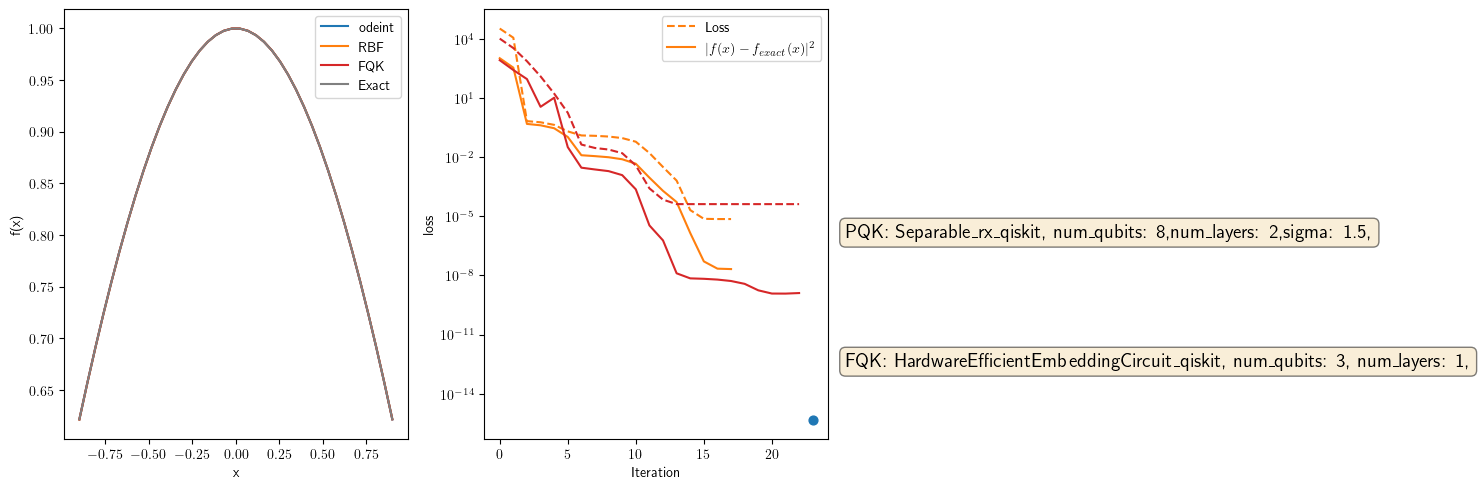

In [ ]:



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


x_span_plot = x_line.reshape(-1, 1)
ax1.plot(x_span_plot, f_odeint,label="odeint", color="C0")
ax1.plot(x_span_plot, f_RBF,  label="RBF", color="C1")
#ax1.plot(x_span_plot, f_PQK, label="PQK", color="C2")
ax1.plot(x_span_plot, f_FQK, label="FQK", color="C3")
ax1.plot(x_span_plot, f_exact, label="Exact", color="gray")


ax1.set_ylabel("f(x)")
ax1.set_xlabel("x")
ax1.legend()

str_PQK_info = PQK_solver_test.print_plotting_relevant_info()
str_FQK_info = FQK_solver_test.print_plotting_relevant_info()

#ax2 is for the errors
ax2.plot(loss_by_iteration_RBF[0], color="C1", linestyle="--", label="Loss")
ax2.plot(get_full_loss(loss_by_iteration_RBF[1], f_exact), color="C1", label="$|f(x)-f_{exact}(x)|^2$")

#ax2.plot(loss_by_iteration_PQK[0], color="C2", linestyle="--",)
#ax2.plot(get_full_loss(loss_by_iteration_PQK[1], f_exact), color="C2", )

ax2.plot(loss_by_iteration_FQK[0], color="C3", linestyle="--", )
ax2.plot(get_full_loss(loss_by_iteration_FQK[1], f_exact), color="C3", )

ax2.scatter(len(loss_by_iteration_FQK[0]), np.mean((f_odeint-f_exact)**2), color="C0", s=40)

ax2.set_yscale("log")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("loss")

ax2.legend()


#add a txt box with the relevant info to the right of the plot
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax2.text(1.05, 0.5, str_PQK_info, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax2.text(1.05, 0.2, str_FQK_info, transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


plt.suptitle(r"$\frac{ d^2 f}{dx^2} = -kx$ ")


plt.tight_layout()
plt.show()


# QNN DE Solver

In [ ]:
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor
from squlearn.qnn.lowlevel_qnn import LowLevelQNN
from squlearn.optimizers import SLSQP, Adam
from squlearn.qnn.loss import *
from squlearn.qnn.training import *
from DE_Library.qnn_and_kernels_wrappers import ODELoss_wrapper



num_qubits = 1
num_features = 1
num_layers = 3
circuit = SimpleAnalyticalCircuit(num_qubits, num_features, num_layers)
executor = Executor("pennylane")

Observables = SummedPaulis(num_qubits, include_identity=False)                                                      
param_obs = Observables.generate_initial_parameters(seed=1)
#param_ini = params_ini_for_qnn_log
param_ini = circuit.generate_initial_parameters(seed=1)


maxiter = 100

slsqp = SLSQP(options={"maxiter": 150, "ftol": 0.05})
log_file = "SHO_DE.log"
adam = Adam(options={"maxiter": maxiter, "tol": 0.00009, "log_file": log_file, "skip_mse_fun":False})

loss_ODE = ODELoss_wrapper(loss_harmonic_oscillator, grad_loss_harmonic_oscillator, initial_vec = f_initial, eta=1, true_solution = f_exact)
#loss_ODE = ODELoss_wrapper(loss_harmonic_oscillator, grad_loss_harmonic_oscillator, initial_vec = f_initial, eta=1, true_solution = None)


clf = QNNRegressor(
    circuit,
    Observables,
    executor,
    loss_ODE,
    adam,
    param_ini,
    param_obs,
    opt_param_op = False, #Parametrized Observables not benchmarked yet
)



In [ ]:
y_ODE = np.zeros((x_line.shape[0]))
clf._fit(x_line, y_ODE,  weights=None)
f_QNN = clf.predict(x_line)

fit:   0%|          | 0/100 [00:00<?, ?it/s]PARAM [-0.52136612  1.38433962 -3.14087402]
INPUT [-0.9        -0.85384615 -0.80769231 -0.76153846 -0.71538462 -0.66923077
 -0.62307692 -0.57692308 -0.53076923 -0.48461538 -0.43846154 -0.39230769
 -0.34615385 -0.3        -0.25384615 -0.20769231 -0.16153846 -0.11538462
 -0.06923077 -0.02307692  0.02307692  0.06923077  0.11538462  0.16153846
  0.20769231  0.25384615  0.3         0.34615385  0.39230769  0.43846154
  0.48461538  0.53076923  0.57692308  0.62307692  0.66923077  0.71538462
  0.76153846  0.80769231  0.85384615  0.9       ]
current LOSS [3.29926994]
(40,) (40,)
using this
fit:   1%|          | 1/100 [00:05<08:34,  5.19s/it]PARAM [-0.47136612  1.43433962 -3.09087402]
INPUT [-0.9        -0.85384615 -0.80769231 -0.76153846 -0.71538462 -0.66923077
 -0.62307692 -0.57692308 -0.53076923 -0.48461538 -0.43846154 -0.39230769
 -0.34615385 -0.3        -0.25384615 -0.20769231 -0.16153846 -0.11538462
 -0.06923077 -0.02307692  0.02307692  0.06923077

In [ ]:
loss_history_qnn_df = pd.read_csv(log_file, delim_whitespace=True)

C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_24252\972887894.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss_history_qnn_df = pd.read_csv(log_file, delim_whitespace=True)


In [ ]:
loss_history_qnn_df

,Iteration,f(x),MSE,Gradient,Step,Eff.,LR,LR.1
0,1,3.29927,2.20845,2.63357,0.08660,0.05000,0.05,NaN
1,2,3.05746,1.95021,2.94029,0.11677,0.03712,0.05,NaN
2,3,2.69490,1.59158,3.24828,0.10141,0.03180,0.05,NaN
3,4,2.35649,1.28776,3.40863,0.09593,0.02886,0.05,NaN
4,5,2.02609,1.01993,3.46381,0.09318,0.02703,0.05,NaN
...,...,...,...,...,...,...,...,...
95,96,0.00003,0.00001,0.01969,0.00177,0.03934,0.05,NaN
96,97,0.00001,0.00000,0.00905,0.00169,0.03946,0.05,NaN
97,98,0.00000,0.00000,0.00110,0.00152,0.03958,0.05,NaN
98,99,0.00001,0.00000,0.01024,0.00129,0.03970,0.05,NaN


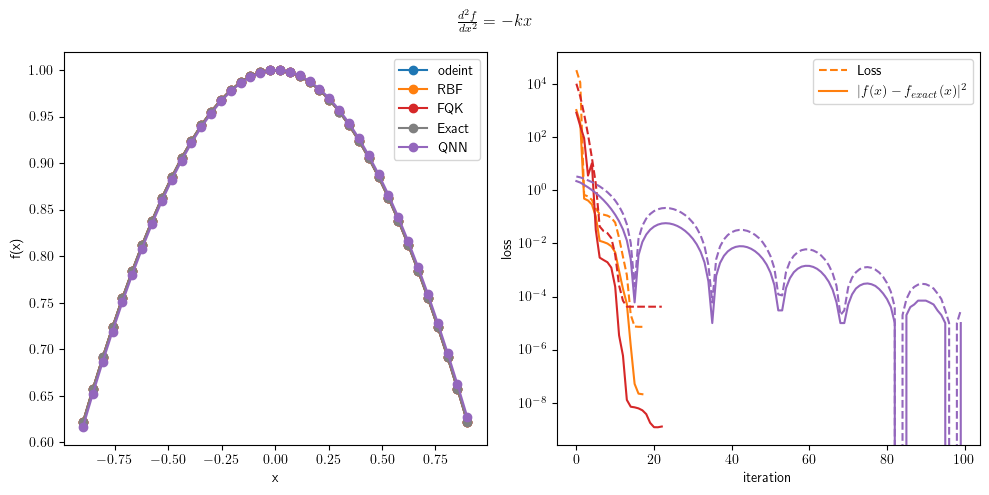

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


x_span_plot = x_line.reshape(-1, 1)
ax1.plot(x_span_plot, f_odeint,"-o", label="odeint", color="C0")
ax1.plot(x_span_plot, f_RBF, "-o", label="RBF", color="C1")
#ax1.plot(x_span_plot, f_PQK, "-o", label="PQK", color="C2")
ax1.plot(x_span_plot, f_FQK, "-o", label="FQK", color="C3")
ax1.plot(x_span_plot, np.cos(x_span_plot),  "-o", label="Exact", color="gray")
ax1.plot(x_span_plot, f_QNN, "-o", label="QNN", color="C4")
#plt.ylim(-3, 3)


ax1.set_ylabel("f(x)")
ax1.set_xlabel("x")
ax1.legend()

str_PQK_info = PQK_solver_test.print_plotting_relevant_info()
str_FQK_info = FQK_solver_test.print_plotting_relevant_info()

#ax2 is for the errors
ax2.plot(loss_by_iteration_RBF[0], color="C1", linestyle="--", label="Loss")
ax2.plot(get_full_loss(loss_by_iteration_RBF[1], f_exact),  color="C1", label="$|f(x)-f_{exact}(x)|^2$")

#ax2.plot(loss_by_iteration_PQK[0], color="C2", linestyle="--",)
#ax2.plot(get_full_loss(loss_by_iteration_PQK[1], f_exact), color="C2", )

ax2.plot(loss_by_iteration_FQK[0], color="C3", linestyle="--", )
ax2.plot(get_full_loss(loss_by_iteration_FQK[1], f_exact), color="C3", )

if len(loss_history_qnn_df["f(x)"]) >= 5: #If 
        ax2.plot(loss_history_qnn_df["f(x)"], color="C4", linestyle="--", )
else:
        ax2.axhline(loss_history_qnn_df["f(x)"].iloc[-1], color="C4", linestyle="--", ) #Quality of Loss in QNN

ax2.plot(loss_history_qnn_df["MSE"], color="C4", linestyle="-", )



ax2.set_ylabel("loss")
ax2.set_xlabel("iteration")
ax2.set_yscale("log")

ax2.legend()

plt.suptitle(r"$\frac{ d^2 f}{dx^2} = -kx$ ")
#add a txt box with the relevant info to the right of the plot
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax2.text(1.05, 0.5, str_PQK_info, transform=ax2.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)
#ax2.text(1.05, 0.2, str_FQK_info, transform=ax2.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()
